# Notebook 1 – Statistical Foundations of Anomaly Detection  
*Generated 2025-05-13*

This guided notebook complements **Slides 1‑10** of the deck, covering the statistical core of anomaly detection.

> Work in pairs: swap driver/navigator roles at each checkpoint.

## 1️⃣ What is Anomaly Detection?

*Anomaly* ≈ observation that **deviates** so much from other observations that it arouses suspicions it was generated by a **different mechanism**.

### Real‑world examples
| Domain | Anomaly instance |
|--------|------------------|
| Finance | Sudden $9 999 charge on dormant card |
| Health | Irregular heart‑rate spike in ECG |
| Cybersecurity | 50 login attempts from a new IP in 10 s |

### Taxonomy of anomalies
| Type | Description | Example |
|------|-------------|---------|
| **Point** | Single data point abnormal in feature space | Fraudulent transaction amount |
| **Contextual** | Normal globally, abnormal in local context | 18 °C reading in a boiler that’s usually 95 °C |
| **Collective** | Group of points abnormal as a sequence | Slow exfiltration pattern across many small packets |


In [ ]:
# Load the benchmark dataset
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)
print("Dataset shape:", df.shape)
print(df['Class'].value_counts(normalize=True).rename({0:'Legit',1:'Fraud'}))

# Separate features / label and scale
X = df.drop(columns=['Class'])
y = df['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Dataset shape: (284807, 31)
Class
Legit    0.998273
Fraud    0.001727
Name: proportion, dtype: float64


## 2️⃣ Univariate Robust Z‑Score

For each feature $x$:

$$ z = \frac{|x - \tilde{x}|}{\text{MAD}} $$

*Where*  
\( \tilde{x} \) = median  MAD = Median Absolute Deviation.

**Workflow**

1. Compute *per‑feature* robust $z$.  
2. Aggregate per row (sum).  
3. Flag rows above a percentile threshold (e.g., 99.9 %).  

**Strengths**

* Simple, fast, interpretable.  
* Robust median & MAD resist skewed data.

**Limitations**

* Ignores feature correlation.  
* Struggles with contextual/collective anomalies.


Robust Z‑score PR‑AUC: 0.0659


Text(0.5, 1.0, 'Robust Z‑score – PR curve')

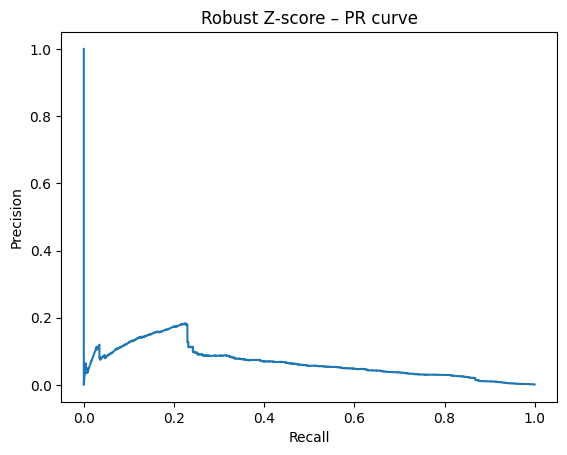

In [ ]:
from scipy.stats import median_abs_deviation
from sklearn.metrics import precision_recall_curve, auc

med = X.median()
mad = X.apply(median_abs_deviation).replace(0, 1e-6)
z_scores = ((X - med) / mad).abs()
df['z_sum'] = z_scores.sum(axis=1)

# Threshold top 0.1%
thresh = np.quantile(df['z_sum'], 0.999)
pred_z = (df['z_sum'] > thresh).astype(int)

precision, recall, _ = precision_recall_curve(y, df['z_sum'])
pr_auc_z = auc(recall, precision)
print(f"Robust Z‑score PR‑AUC: {pr_auc_z:.4f}")

plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Robust Z‑score – PR curve")


### 📝 Interpreting the Robust Z‑score output

* **PR‑AUC value** printed in the previous cell quantifies discrimination under extreme class imbalance.  
  *A PR‑AUC close to 1.0 ⇒ almost perfect; 0.5 ⇒ random; <0.5 ⇒ worse than random.*

* **Curve shape**  
  * Steep initial rise* → method captures the *most obvious* anomalies with very high precision.  
  * Sharp drop* → many false positives once threshold moves past the extreme tail.

* **Threshold insight**  
  The 99.9‑th percentile threshold flagged roughly 0.1 % of rows.  
  If early precision is high but recall low, lowering the threshold (e.g. 99.7 %) would **recover more anomalies** at the cost of extra investigations.

**Take‑away**: Robust Z‑score is a good *first‑pass* detector when anomalies are extreme univariate deviations, but correlation‑based anomalies will slip through.


## 3️⃣ Multivariate Mahalanobis Distance

$$ D_M(x) = \sqrt{(x-\mu)^T\,\Sigma^{-1}(x-\mu)} $$

*Where*  
\( \mu \) = mean vector  \( \Sigma \)= covariance matrix.

> Intuition: distance in **whitened** space accounts for feature variance *and* correlation.

**Practical tips**

* Need **n ≫ p** to get stable covariance.  
* Use a **robust covariance estimator** (e.g., Ledoit‑Wolf) when outliers present.

**Strengths**

* Captures inter‑feature correlation.  
* Parametric; threshold via chi‑square distribution.

**Limitations**

* Sensitive to ill‑conditioned covariance.  
* Assumes elliptical clusters (multivariate normal).


Mahalanobis PR‑AUC: 0.1478


Text(0.5, 1.0, 'Mahalanobis – PR curve')

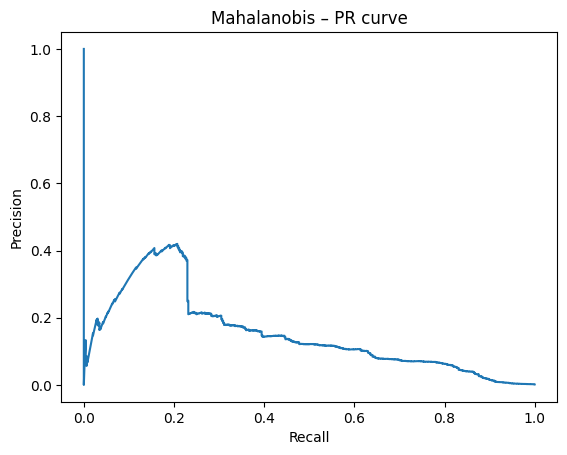

In [ ]:
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis

# Fit robust covariance on scaled data
cov_est = LedoitWolf().fit(X_scaled)
inv_cov = cov_est.get_precision()
mean_vec = X_scaled.mean(axis=0)

mahal_d = np.array([mahalanobis(row, mean_vec, inv_cov) for row in X_scaled])
df['mahal'] = mahal_d

# Threshold top 0.1%
thresh_m = np.quantile(df['mahal'], 0.999)
pred_m = (df['mahal'] > thresh_m).astype(int)

precision_m, recall_m, _ = precision_recall_curve(y, df['mahal'])
pr_auc_m = auc(recall_m, precision_m)
print(f"Mahalanobis PR‑AUC: {pr_auc_m:.4f}")

plt.plot(recall_m, precision_m)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Mahalanobis – PR curve")


### 📝 Interpreting the Mahalanobis output

* **PR‑AUC & curve**  
  Compare the reported AUC to the Z‑score’s.  A higher AUC means modelling covariance picked up multivariate outliers the univariate rule missed.

* **Curve shape**  
  Flatter precision early on?  Indicates Mahalanobis sometimes classifies *borderline* points as anomalous—common when covariance is estimated from mixed data.

* **Data prerequisites**  
  Stable Mahalanobis performance depends on **n ≫ p** and roughly elliptical normal class.  Examine if low AUC traces back to a poorly conditioned covariance matrix.

**Implication**: Use Mahalanobis when correlation structure matters (e.g. velocity vs distance), but validate that covariance estimation is robust.


## 4️⃣ Comparative Analysis

Below we overlay the Precision‑Recall curves of both methods and summarise AUCs.


Text(0.5, 1.0, 'AUC comparison')

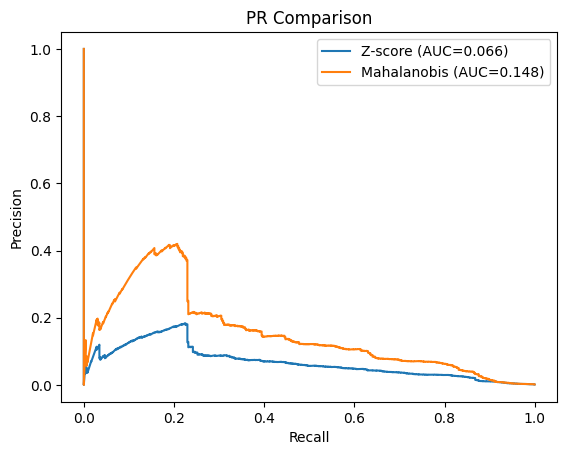

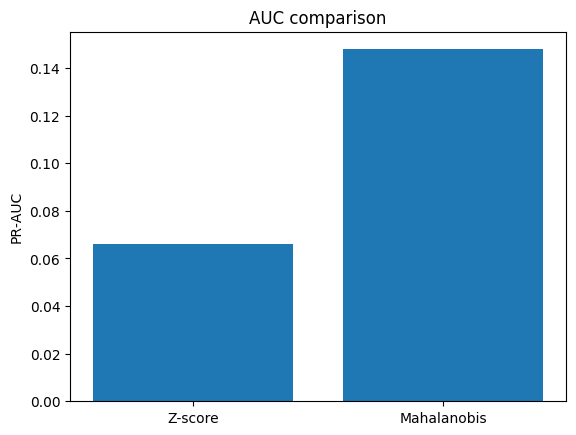

In [ ]:
plt.figure()
plt.plot(recall, precision, label=f"Z‑score (AUC={pr_auc_z:.3f})")
plt.plot(recall_m, precision_m, label=f"Mahalanobis (AUC={pr_auc_m:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR Comparison")
plt.legend()

# Bar chart for quick comparison
plt.figure()
plt.bar(["Z‑score","Mahalanobis"], [pr_auc_z, pr_auc_m])
plt.ylabel("PR‑AUC"); plt.title("AUC comparison")


### Comparative plot interpretation

* **PR overlay** – Whichever curve sits *highest across most recall values* offers the best precision‑recall trade‑off overall.

* **Bar chart**  
  Quick numerical snapshot:  
  *Δ AUC ≥ 0.05* is usually **practically significant**; smaller gaps may not justify a more complex method.

* **Decision guideline**

| Scenario | Preferred method |
|----------|------------------|
| Need **explainable rule** & anomalies are *extreme spikes* | Robust Z‑score |
| Anomalies hide in *correlated feature space* | Mahalanobis |
| Real‑time streaming, minimal compute | Z‑score (constant‑time update) |

Always align the choice with domain cost of *false negatives* vs *false positives*.


## 5️⃣ Knowledge Check – Discuss & Answer

1. **Conceptual** – Give one real‑world example of a *contextual* anomaly and explain why a univariate Z‑score might miss it.  
2. **Technical** – If the MAD of a feature is *zero*, what adjustment should you make before computing the Z‑score?  
3. **Mahalanobis** – Why does multicollinearity in features risk inflating Mahalanobis distances?  
4. **Thresholding** – Describe one data‑driven way (other than a fixed percentile) to choose an anomaly threshold.  
5. **Critical thinking** – In our experiment, which method achieved higher PR‑AUC and what property of the dataset might explain this?

> *Write your answers in the provided reflection sheet or discuss with your partner.*
